In [1]:
# General Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
import xgboost as xgb

# Deep Learning (LSTM)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Metrics for Model Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Time Series Analysis
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima


In [2]:
all_data_daily_path = 'merged_data_granualityBased/_data_(daily).csv'

In [3]:
all_data_daily = pd.read_csv(all_data_daily_path)

In [4]:
all_data_daily.head()

,date,loadConsumption,DailyPrecipitation,MaxHourlyPrecipitation,DailyMeanTemperature,HourlyMinTemperature,HourlyMaxTemperature,DailyMeanWindspeed,MaxHourlyMeanWindspeed,MinHourlyMeanWindspeed,...,TotalBiomass (MWh),TotalRes(incl.Stat.Transfer) (MWh),Totaal windenergie (MWh),TotalSolarEnergy (MWh),Total Including Non-Renewable (MWh),AveragePrice_Electricity_Household,AveragePrice_Electricity_NonHousehold,AveragePrice_NaturalGas_Household,AveragePrice_NaturalGas_NonHousehold,GDP
0,2009-01-01,280721.0,0.0,0.0,-0.6,-28,0.5,1.6,2.0,1.0,...,20485441.66,26016874.8,4480869.18,302224.64,6.098754e+08,0.1424,0.134429,0.856667,0.5046,655958
1,2009-01-01,280721.0,0.0,0.0,-0.6,-28,0.5,1.6,2.0,1.0,...,20485441.66,26016874.8,4480869.18,302224.64,6.098754e+08,0.1424,0.134429,0.856667,0.5046,624842
2,2009-01-02,297433.0,0.5,0.5,-0.8,-72,1.9,2.2,5.0,1.0,...,20485441.66,26016874.8,4480869.18,302224.64,6.098754e+08,0.1424,0.134429,0.856667,0.5046,655958
3,2009-01-02,297433.0,0.5,0.5,-0.8,-72,1.9,2.2,5.0,1.0,...,20485441.66,26016874.8,4480869.18,302224.64,6.098754e+08,0.1424,0.134429,0.856667,0.5046,624842
4,2009-01-03,307080.0,-0.1,-0.1,-2.7,-89,1.6,1.9,3.0,0.0,...,20485441.66,26016874.8,4480869.18,302224.64,6.098754e+08,0.1424,0.134429,0.856667,0.5046,655958


### Stationary Check

In [5]:
# Check for stationarity using Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("Data is stationary")
    else:
        print("Data is NOT stationary")

In [6]:
adf_test(all_data_daily["loadConsumption"])

ADF Statistic: -5.228233945867829
p-value: 7.697152732243103e-06
Data is stationary


In [7]:
data = all_data_daily.copy()

In [8]:
data["date"] = pd.to_datetime(data["date"])

In [9]:
data.isna().sum()

date                                     0
loadConsumption                          0
DailyPrecipitation                       0
MaxHourlyPrecipitation                   0
DailyMeanTemperature                     0
HourlyMinTemperature                     0
HourlyMaxTemperature                     0
DailyMeanWindspeed                       0
MaxHourlyMeanWindspeed                   0
MinHourlyMeanWindspeed                   0
Month                                    0
Year                                     0
Week                                     0
day_of_week                              0
Population                               0
TotalBiomass (MWh)                       0
TotalRes(incl.Stat.Transfer) (MWh)       0
Totaal windenergie (MWh)                 0
TotalSolarEnergy (MWh)                   0
Total Including Non-Renewable (MWh)      0
AveragePrice_Electricity_Household       0
AveragePrice_Electricity_NonHousehold    0
AveragePrice_NaturalGas_Household        0
AveragePric

### Correlation Matrix of Electricity Load and Explanatory Variables

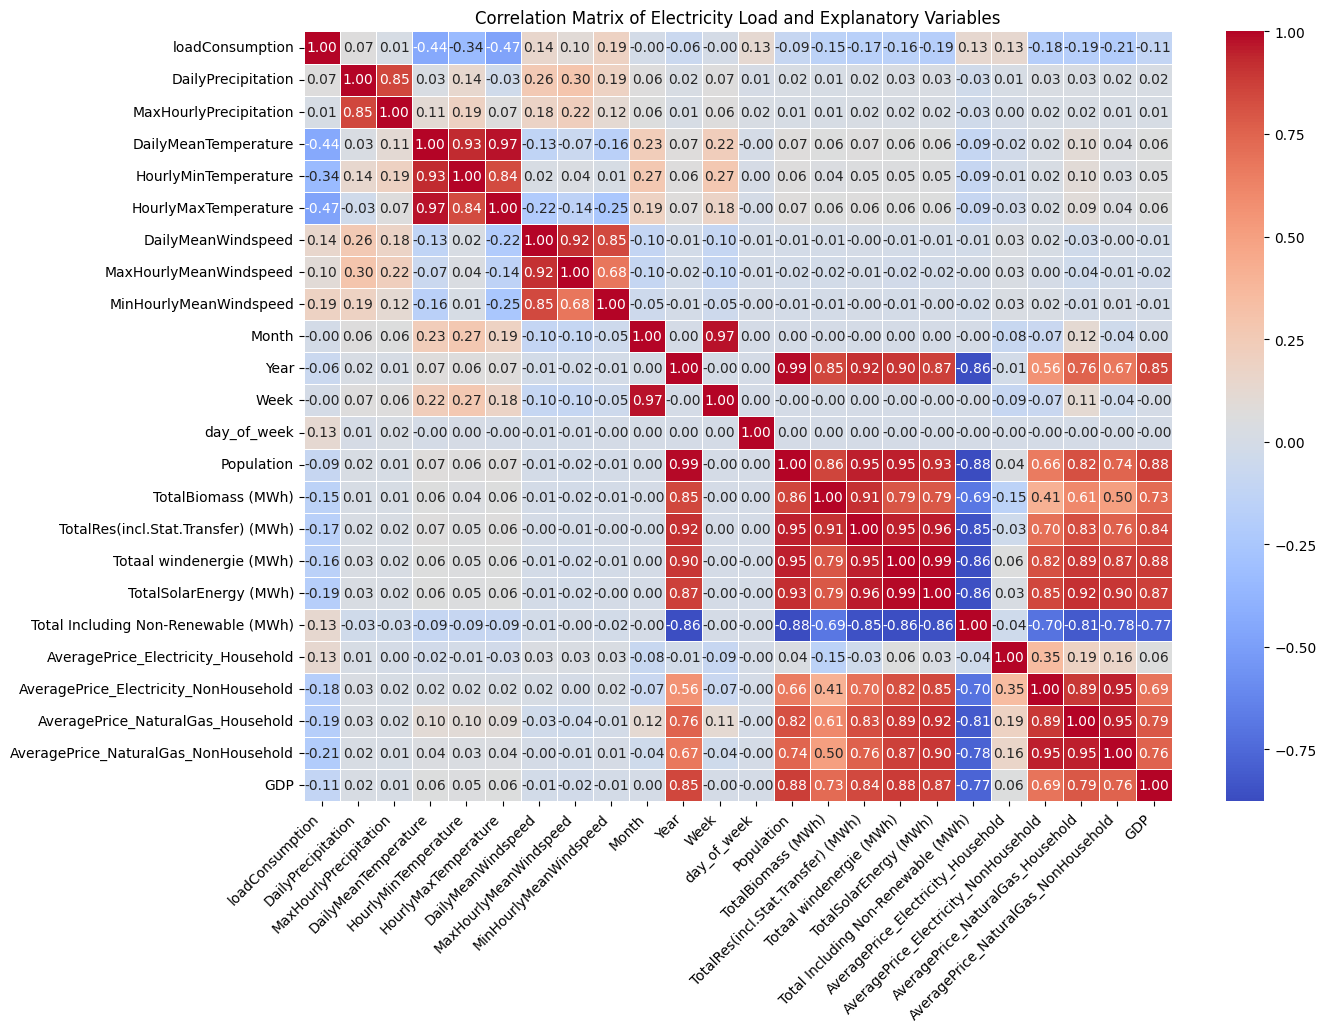

In [10]:
numeric_cols = data.select_dtypes(include=["number"])

# Compute correlation matrix
corr_matrix = numeric_cols.corr()

plt.figure(figsize=(14, 10))  
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Electricity Load and Explanatory Variables")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels
plt.yticks(rotation=0)  
plt.show()

In [11]:
features_to_drop = [
    "Total Including Non-Renewable (MWh)",  
    "AveragePrice_NaturalGas_NonHousehold",  
    "AveragePrice_Electricity_NonHousehold",
]

# Drop selected features
data = data.drop(columns=features_to_drop)



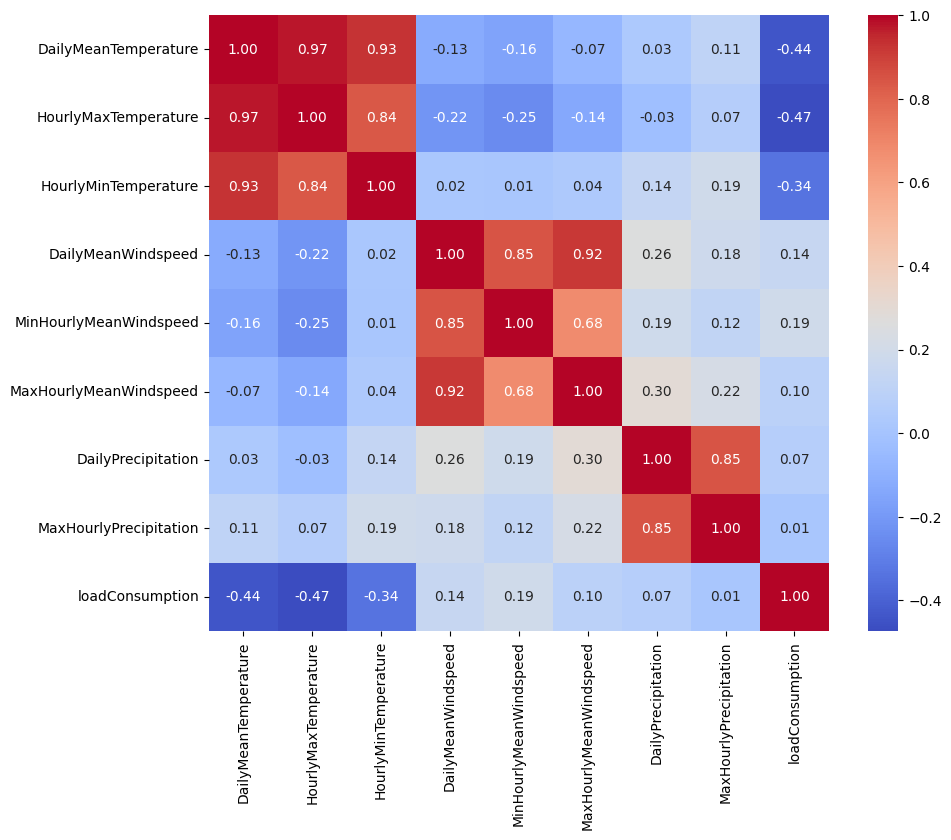

In [12]:
weather_features = ['DailyMeanTemperature', 'HourlyMaxTemperature', 'HourlyMinTemperature',
                    'DailyMeanWindspeed', 'MinHourlyMeanWindspeed', 'MaxHourlyMeanWindspeed',
                    'DailyPrecipitation', 'MaxHourlyPrecipitation']

# Correlation matrix
corr_matrix = data[weather_features + ['loadConsumption']].corr()

# Plot correlations for visual inspection
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [13]:
featuresWeather_to_drop = [
    "MaxHourlyPrecipitation",  
    "HourlyMinTemperature",  
    "HourlyMaxTemperature",  
    "MinHourlyMeanWindspeed",
    "MaxHourlyMeanWindspeed"
]

# Drop selected features
data = data.drop(columns=featuresWeather_to_drop)


### VIF analysis

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select only numeric features for VIF analysis
numeric_features = data.select_dtypes(include=[np.number]).dropna()

# Exclude the target variable 'loadConsumption'
features_for_vif = numeric_features.drop(columns=['loadConsumption'])

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = features_for_vif.columns
vif_data["VIF"] = [variance_inflation_factor(features_for_vif.values, i) 
                   for i in range(features_for_vif.shape[1])]


# Display VIF results sorted by highest VIF first
vif_data.sort_values(by="VIF", ascending=False, inplace=True)

In [15]:
vif_data

,Feature,VIF
7,Population,59444.228750
4,Year,49589.102088
9,TotalRes(incl.Stat.Transfer) (MWh),377.358985
8,TotalBiomass (MWh),351.194772
11,TotalSolarEnergy (MWh),234.740750
10,Totaal windenergie (MWh),96.482543
3,Month,17.869185
5,Week,17.621444
13,AveragePrice_NaturalGas_Household,13.457410
12,AveragePrice_Electricity_Household,7.461239


### PCA

In [16]:
from sklearn.decomposition import PCA

# Copy data to avoid modifying original
df_pca = data.copy()

# 1. Economic Features PCA
economic_features = ['Population', 'GDP']
economic_scaled = StandardScaler().fit_transform(df_pca[economic_features])

pca_economic = PCA(n_components=1)
economic_component = pca_economic.fit_transform(economic_scaled)
df_pca['Economic_Component'] = economic_component

print("Economic PCA Explained Variance:", pca_economic.explained_variance_ratio_)

# 2. Renewable Energy Features PCA
renewable_features = ['TotalSolarEnergy (MWh)', 
                      'Totaal windenergie (MWh)', 
                      'TotalBiomass (MWh)',
                      'TotalRes(incl.Stat.Transfer) (MWh)']
renewable_scaled = StandardScaler().fit_transform(df_pca[renewable_features])

pca_renewable = PCA(n_components=1)
renewable_component = pca_renewable.fit_transform(renewable_scaled)
df_pca['RenewableEnergy_Component'] = renewable_component

print("Renewable PCA Explained Variance:", pca_renewable.explained_variance_ratio_)



# Drop original columns after PCA (optional)
df_pca.drop(columns=economic_features + renewable_features, inplace=True)

Economic PCA Explained Variance: [0.93847179]
Renewable PCA Explained Variance: [0.92648012]


In [17]:
df_pca

,date,loadConsumption,DailyPrecipitation,DailyMeanTemperature,DailyMeanWindspeed,Month,Year,Week,day_of_week,AveragePrice_Electricity_Household,AveragePrice_NaturalGas_Household,Economic_Component,RenewableEnergy_Component
0,2009-01-01,280721.0000,0.0,-0.6,1.6,1,2009,1,4,0.1424,0.856667,-1.631259,-1.744467
1,2009-01-01,280721.0000,0.0,-0.6,1.6,1,2009,1,4,0.1424,0.856667,-1.867947,-1.744467
2,2009-01-02,297433.0000,0.5,-0.8,2.2,1,2009,1,0,0.1424,0.856667,-1.631259,-1.744467
3,2009-01-02,297433.0000,0.5,-0.8,2.2,1,2009,1,0,0.1424,0.856667,-1.867947,-1.744467
4,2009-01-03,307080.0000,-0.1,-2.7,1.9,1,2009,1,2,0.1424,0.856667,-1.631259,-1.744467
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10951,2023-12-29,314575.3300,3.8,9.3,6.0,12,2023,52,0,0.2128,1.671333,3.681673,3.832929
10952,2023-12-30,290563.1625,-0.1,8.1,4.2,12,2023,52,2,0.2128,1.671333,1.956974,3.832929
10953,2023-12-30,290563.1625,-0.1,8.1,4.2,12,2023,52,2,0.2128,1.671333,3.681673,3.832929
10954,2023-12-31,296833.7350,2.8,8.8,6.4,12,2023,52,3,0.2128,1.671333,1.956974,3.832929


### Generate features

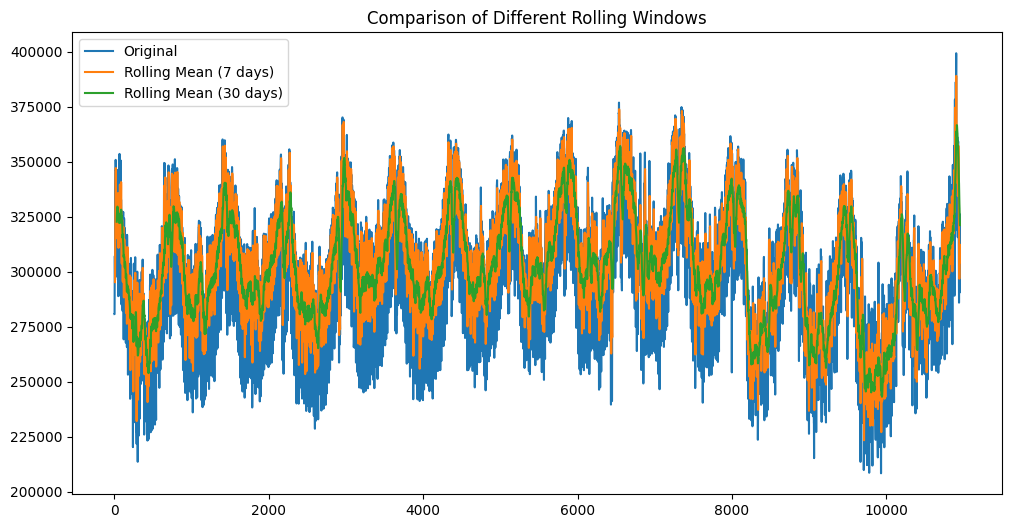

In [18]:
plt.figure(figsize=(12,6))
plt.plot(data['loadConsumption'], label='Original')
plt.plot(data['loadConsumption'].rolling(window=7).mean(), label='Rolling Mean (7 days)')
plt.plot(data['loadConsumption'].rolling(window=30).mean(), label='Rolling Mean (30 days)')
#plt.plot(data['loadConsumption'].rolling(window=90).mean(), label='Rolling Mean (90 days)')
plt.legend()
plt.title('Comparison of Different Rolling Windows')
# Save the plot with better quality
plt.savefig("plots/rolling_mean_comparison.png", dpi=300, bbox_inches='tight', transparent=False)

# Show the plot
plt.show()

In [19]:
from pandas.tseries.holiday import USFederalHolidayCalendar  # Adjust based on your region

def create_time_features(data, target_column='loadConsumption'):
    """
    Generate time-based features for time series forecasting.
    
    Parameters:
    - data (DataFrame): The original dataset containing a 'date' column.
    - target_column (str): The target variable for rolling features.
    
    Returns:
    - data (DataFrame): The updated DataFrame with new features.
    """

    # Ensure 'date' is a datetime index
    data['date'] = pd.to_datetime(data['date'])
    data = data.set_index('date')

    # Create 'is_weekend' feature (1 if Saturday/Sunday, else 0)
    data['is_weekend'] = data.index.weekday.isin([5, 6]).astype(int)

    # Create 'is_holiday' feature (1 if a holiday, else 0)
    cal = USFederalHolidayCalendar()  # You can replace with a different holiday calendar
    holidays = cal.holidays(start=data.index.min(), end=data.index.max())
    data['is_holiday'] = data.index.isin(holidays).astype(int)

    # Create 'day_of_year' feature 
    data['day_of_year'] = data.index.dayofyear.astype(int)

    # Create rolling mean features for the target variable
    data['rolling_7'] = data[target_column].rolling(window=7, min_periods=1).mean()
    data['rolling_30'] = data[target_column].rolling(window=30, min_periods=1).mean()
    data['rolling_365'] = data[target_column].rolling(window=365, min_periods=1).mean()

    return data

In [20]:
data_filtered = create_time_features(df_pca)

In [21]:
data_filtered.columns

Index(['loadConsumption', 'DailyPrecipitation', 'DailyMeanTemperature',
       'DailyMeanWindspeed', 'Month', 'Year', 'Week', 'day_of_week',
       'AveragePrice_Electricity_Household',
       'AveragePrice_NaturalGas_Household', 'Economic_Component',
       'RenewableEnergy_Component', 'is_weekend', 'is_holiday', 'day_of_year',
       'rolling_7', 'rolling_30', 'rolling_365'],
      dtype='object')

In [22]:
df_models = data_filtered.copy()

#### Features

In [23]:
feature_sets = {
    "Exogenous Features": [
        'DailyMeanTemperature',
        'DailyMeanWindspeed',
        'DailyPrecipitation',
        'day_of_week',
        'AveragePrice_Electricity_Household',
        'AveragePrice_NaturalGas_Household',
        'Economic_Component',
        'RenewableEnergy_Component'
    ],
    
    "Generated Features": [
        'is_weekend',
        'is_holiday',
        'day_of_year',
        'rolling_7',
        'rolling_30',
        'rolling_365'
    ],
    "Both Exogenous & Generated": [
        'DailyMeanTemperature',
        'DailyMeanWindspeed',
        'DailyPrecipitation',
        'day_of_week',
        'AveragePrice_Electricity_Household',
        'AveragePrice_NaturalGas_Household',
        'Economic_Component',
        'RenewableEnergy_Component',
        'is_weekend',
        'is_holiday',
        'day_of_year',
        'rolling_7',
        'rolling_30',
        'rolling_365'
        
    ]
}

## Test with different models

### SARIMAX| BASELINE

##### Autocorrelation Function (ACF) & Partial Autocorrelation Function (PACF)

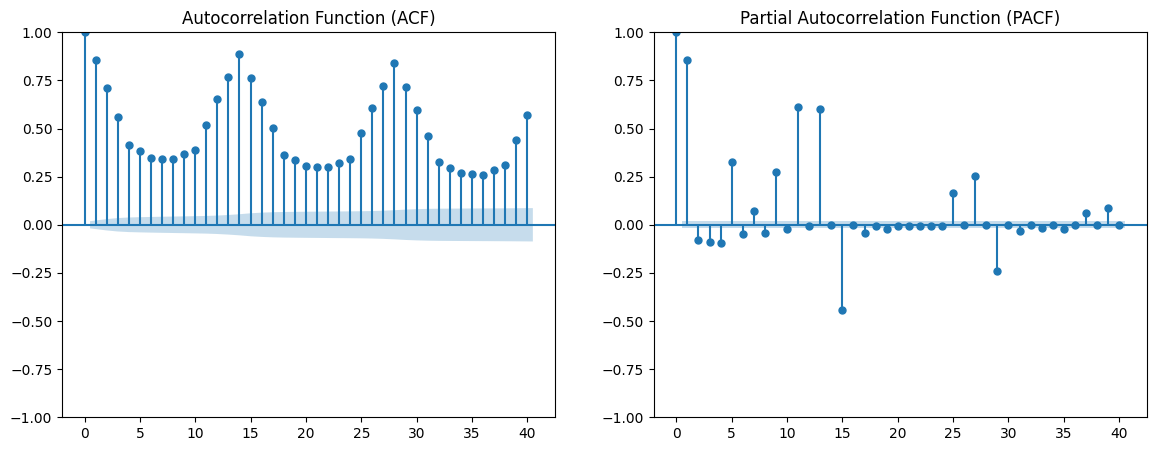

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Ensure date is in datetime format and set as index
all_data_daily['date'] = pd.to_datetime(all_data_daily['date'])
all_data_daily.set_index('date', inplace=True)

# Extract the target variable for ARIMA
load_consumption = all_data_daily['loadConsumption']

# Plot ACF and PACF to determine ARIMA parameters
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# ACF plot
plot_acf(load_consumption, ax=ax[0], lags=40)
ax[0].set_title("Autocorrelation Function (ACF)")

# PACF plot
plot_pacf(load_consumption, ax=ax[1], lags=40)
ax[1].set_title("Partial Autocorrelation Function (PACF)")

plt.savefig('plots\P(ACF).png', dpi=300)

plt.show()

In [25]:
df_sarimax = df_models

In [26]:
df_sarimax.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10956 entries, 2009-01-01 to 2023-12-31
Data columns (total 18 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   loadConsumption                     10956 non-null  float64
 1   DailyPrecipitation                  10956 non-null  float64
 2   DailyMeanTemperature                10956 non-null  float64
 3   DailyMeanWindspeed                  10956 non-null  float64
 4   Month                               10956 non-null  int64  
 5   Year                                10956 non-null  int64  
 6   Week                                10956 non-null  int64  
 7   day_of_week                         10956 non-null  int64  
 8   AveragePrice_Electricity_Household  10956 non-null  float64
 9   AveragePrice_NaturalGas_Household   10956 non-null  float64
 10  Economic_Component                  10956 non-null  float64
 11  RenewableEnergy_Componen

In [27]:
def run_sarimax_multiple_horizons(train_df, test_df, feature_sets, horizons,
                                  target_col='loadConsumption',
                                  order=(1, 1, 1), seasonal_order=(0, 0, 0, 0)):
    results = []

    # Prepare training and test data
    train_df = train_df.copy()
    test_df = test_df.copy()

    # Ensure datetime index
    train_df.index = pd.to_datetime(train_df.index)
    test_df.index = pd.to_datetime(test_df.index)

    # Remove duplicate dates
    train_df = train_df[~train_df.index.duplicated(keep='first')]
    test_df = test_df[~test_df.index.duplicated(keep='first')]

    # Assign daily frequency
    train_df = train_df.asfreq('D')
    test_df = test_df.asfreq('D')

    for horizon in horizons:
        for fs_name, fs_columns in feature_sets.items():
            y_train = train_df[target_col]
            y_test = test_df[target_col]
            X_train = train_df[fs_columns]
            X_test = test_df[fs_columns]

            try:
                # Fit SARIMAX model
                model = SARIMAX(
                    endog=y_train,
                    exog=X_train,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                ).fit(disp=False)

                # Forecast for the current horizon
                forecast = model.get_forecast(steps=horizon, exog=X_test.iloc[:horizon])
                y_pred = forecast.predicted_mean
                y_true = y_test.iloc[:horizon]

                # Align indices to avoid mismatch
                y_pred.index = y_true.index

                # Calculate metrics safely
                rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                mae = mean_absolute_error(y_true, y_pred)
                mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1, y_true))) * 100
                nrmse = (rmse / y_true.mean()) * 100
                nmae = (mae / y_true.mean()) * 100

                results.append({
                    'Feature Set': fs_name,
                    'Horizon': horizon,
                    'RMSE': rmse,
                    'MAE': mae,
                    'MAPE (%)': mape,
                    'nRMSE (%)': nrmse,
                    'nMAE (%)': nmae,
                })

            except Exception as e:
                print(f"Failed for horizon={horizon}, features={fs_name}: {e}")
                results.append({
                    'Feature Set': fs_name,
                    'Horizon': horizon,
                    'RMSE': None,
                    'MAE': None,
                    'MAPE (%)': None,
                    'nRMSE (%)': None,
                    'nMAE (%)': None,
                })

    return pd.DataFrame(results)

    
def plot_actual_vs_predicted(y_true, y_pred, title='Actual vs Predicted'):
    plt.figure(figsize=(10, 5))
    plt.plot(y_true.index, y_true, label='Actual', marker='o')
    plt.plot(y_pred.index, y_pred, label='Predicted', linestyle='--', marker='x')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Load Consumption')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [28]:
# Define horizons
horizons = [1, 7, 30, 90, 180]

# Split data
train_df, test_df = train_test_split(df_models, test_size=0.2, shuffle=False)

In [29]:
# Run SARIMAX
sarimax_results_df = run_sarimax_multiple_horizons(
    train_df=train_df,
    test_df=test_df,
    feature_sets=feature_sets,
    horizons=horizons,
    target_col='loadConsumption',
    order=(1, 0, 1),
    seasonal_order=(1, 0, 1, 7)
)

C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results w

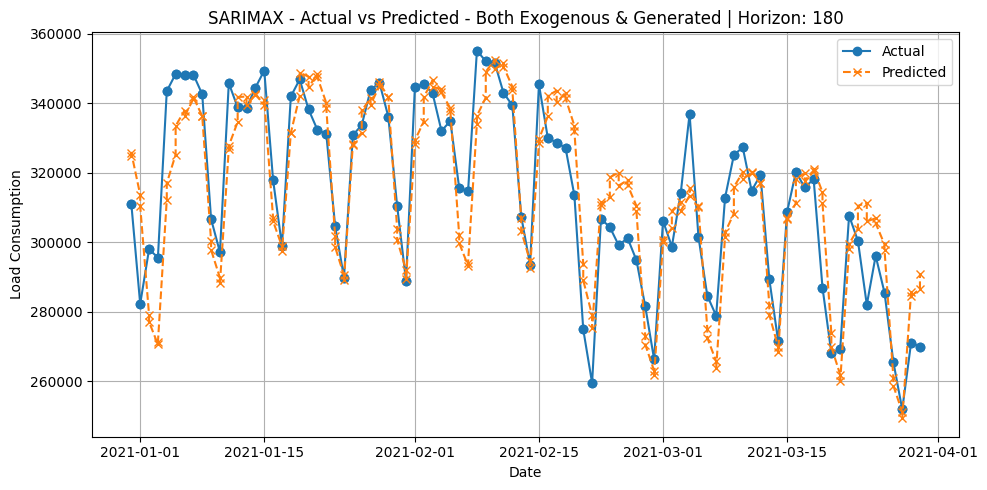

In [30]:
# Choose specific horizon and feature set
chosen_horizon = 180
chosen_feature_set = list(feature_sets.keys())[2]  

# Prepare data
y_train = train_df['loadConsumption']
y_test = test_df['loadConsumption']
X_train = train_df[feature_sets[chosen_feature_set]]
X_test = test_df[feature_sets[chosen_feature_set]]

# Fit and forecast
model = SARIMAX(
    endog=y_train,
    exog=X_train,
    order=(1, 0, 1),
    seasonal_order=(1, 0, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

forecast = model.get_forecast(steps=chosen_horizon, exog=X_test.iloc[:chosen_horizon])
y_pred = forecast.predicted_mean
y_true = y_test.iloc[:chosen_horizon]
y_pred.index = y_true.index

# Plot
plot_actual_vs_predicted(y_true, y_pred, title=f'SARIMAX - Actual vs Predicted - {chosen_feature_set} | Horizon: {chosen_horizon}')


C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results w

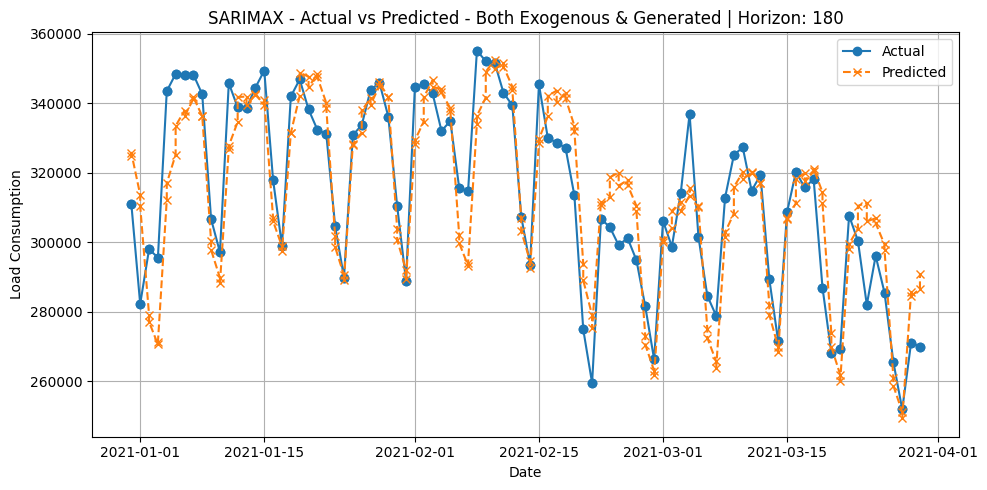

In [31]:
# Make the train/test split first
train_df, test_df = train_test_split(df_models, test_size=0.2, shuffle=False)

# Then prepare and run SARIMAX
chosen_horizon = 180
chosen_feature_set = list(feature_sets.keys())[2]  

# Prepare data
y_train = train_df['loadConsumption']
y_test = test_df['loadConsumption']
X_train = train_df[feature_sets[chosen_feature_set]]
X_test = test_df[feature_sets[chosen_feature_set]]

# Check length of test data
assert len(X_test) >= chosen_horizon, "Test set too small for 180-day forecast."

# Fit and forecast
model = SARIMAX(
    endog=y_train,
    exog=X_train,
    order=(1, 0, 1),
    seasonal_order=(1, 0, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

forecast = model.get_forecast(steps=chosen_horizon, exog=X_test.iloc[:chosen_horizon])
y_pred = forecast.predicted_mean
y_true = y_test.iloc[:chosen_horizon]
y_pred.index = y_true.index

# Plot
plot_actual_vs_predicted(y_true, y_pred, title=f'SARIMAX - Actual vs Predicted - {chosen_feature_set} | Horizon: {chosen_horizon}')


In [32]:
print(X_test.iloc[:180].index.min(), X_test.iloc[:180].index.max())

2020-12-31 00:00:00 2021-03-30 00:00:00


In [33]:
print(len(test_df))  # Should be at least 180 rows

2192


In [34]:
print(X_test.index.freq)
print(X_test.index[:10])
print(X_test.index.to_series().diff().value_counts())

None
DatetimeIndex(['2020-12-31', '2020-12-31', '2021-01-01', '2021-01-01',
               '2021-01-02', '2021-01-02', '2021-01-03', '2021-01-03',
               '2021-01-04', '2021-01-04'],
              dtype='datetime64[ns]', name='date', freq=None)
date
0 days    1096
1 days    1095
Name: count, dtype: int64


C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


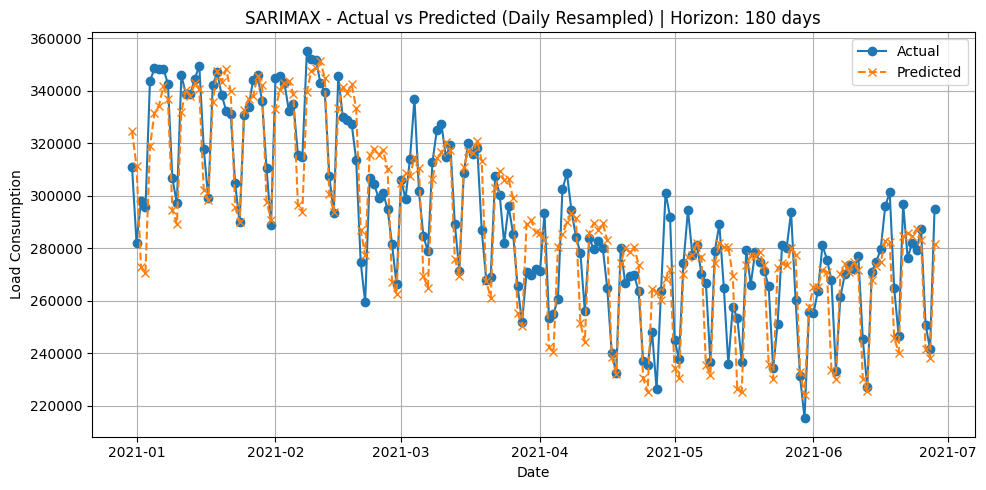

In [35]:
# Step 1: Resample test data to daily frequency
X_test_daily = X_test.resample('D').mean()
y_test_daily = y_test.resample('D').mean()

# Step 2: Drop any missing values that may result from resampling
X_test_daily = X_test_daily.dropna()
y_test_daily = y_test_daily.dropna()

# Step 3: Make sure we have at least 180 days after resampling
assert len(X_test_daily) >= 180, "Not enough daily data for 180-day forecast"

# Step 4: Forecast
forecast = model.get_forecast(steps=180, exog=X_test_daily.iloc[:180])
y_pred = forecast.predicted_mean
y_true = y_test_daily.iloc[:180]

# Step 5: Align index
y_pred.index = y_true.index

# Step 6: Plot
plot_actual_vs_predicted(
    y_true, y_pred,
    title=f'SARIMAX - Actual vs Predicted (Daily Resampled) | Horizon: 180 days'
)

In [36]:
sarimax_results_df

,Feature Set,Horizon,RMSE,MAE,MAPE (%),nRMSE (%),nMAE (%)
0,Exogenous Features,1,7114.630374,7114.630374,2.287454,2.287454,2.287454
1,Generated Features,1,9734.314012,9734.314012,3.129719,3.129719,3.129719
2,Both Exogenous & Generated,1,8856.952985,8856.952985,2.847635,2.847635,2.847635
3,Exogenous Features,7,45825.648311,41346.859706,12.829049,14.403766,12.996008
4,Generated Features,7,18733.993336,17374.299249,5.579470,5.888407,5.461032
5,Both Exogenous & Generated,7,19573.146908,18182.951857,5.830628,6.152167,5.715205
6,Exogenous Features,30,50664.105066,49056.237489,14.920898,15.459034,14.968428
7,Generated Features,30,10149.876302,7171.059720,2.236430,3.097011,2.188091
8,Both Exogenous & Generated,30,10656.286854,7448.665460,2.314860,3.251531,2.272796
9,Exogenous Features,90,40203.292375,36768.507082,11.482424,12.814723,11.719892


### sarimax-lstm

In [37]:
def run_sarimax_lstm_multiple_horizons(train_df, test_df, feature_sets, horizons,
                                       target_col='loadConsumption',
                                       order=(1, 0, 1), seasonal_order=(1, 0, 1, 7),
                                       lstm_steps=30, lstm_units=50, epochs=30, batch_size=32):
    from keras.models import Sequential
    from keras.layers import LSTM, Dense
    from sklearn.preprocessing import MinMaxScaler

    def create_sequences(data, n_steps):
        X, y = [], []
        for i in range(len(data) - n_steps):
            X.append(data[i:i + n_steps])
            y.append(data[i + n_steps])
        return np.array(X), np.array(y)

    results = []

    for horizon in horizons:
        for fs_name, fs_columns in feature_sets.items():
            try:
                y_train = train_df[target_col]
                y_test = test_df[target_col]
                X_train = train_df[fs_columns]
                X_test = test_df[fs_columns]

                # Stage 1: SARIMAX
                sarimax_model = SARIMAX(
                    endog=y_train,
                    exog=X_train,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                ).fit(disp=False)

                sarimax_pred_train = sarimax_model.predict(
                    start=y_train.index[0],
                    end=y_train.index[-1],
                    exog=X_train,
                    dynamic=False
                )
                train_residuals = y_train - sarimax_pred_train

                # Stage 2: LSTM on residuals
                scaler = MinMaxScaler()
                train_residuals_scaled = scaler.fit_transform(train_residuals.values.reshape(-1, 1))

                if len(train_residuals_scaled) < lstm_steps:
                    raise ValueError("Not enough data points for LSTM training")

                X_lstm, y_lstm = create_sequences(train_residuals_scaled, lstm_steps)

                model = Sequential()
                model.add(LSTM(lstm_units, activation='relu', input_shape=(lstm_steps, 1)))
                model.add(Dense(1))
                model.compile(optimizer='adam', loss='mse')
                model.fit(X_lstm, y_lstm, epochs=epochs, batch_size=batch_size, verbose=0)

                # Forecast SARIMAX on test data
                sarimax_forecast = sarimax_model.forecast(steps=horizon, exog=X_test.iloc[:horizon])
                y_true = y_test.iloc[:horizon]
                y_pred_base = sarimax_forecast.values

                # Predict LSTM residuals
                last_sequence = train_residuals_scaled[-lstm_steps:]
                lstm_input = last_sequence.reshape((1, lstm_steps, 1))
                lstm_preds_scaled = []

                for _ in range(horizon):
                    pred = model.predict(lstm_input, verbose=0)
                    lstm_preds_scaled.append(pred[0, 0])
                    lstm_input = np.append(lstm_input[:, 1:, :], [[[pred[0, 0]]]], axis=1)

                lstm_preds_scaled = np.array(lstm_preds_scaled).reshape(-1, 1)
                lstm_preds = scaler.inverse_transform(lstm_preds_scaled).flatten()

                combined_preds = y_pred_base + lstm_preds

                # Evaluation
                rmse = np.sqrt(mean_squared_error(y_true, combined_preds))
                mae = mean_absolute_error(y_true, combined_preds)
                mape = np.mean(np.abs((y_true - combined_preds) / np.where(y_true == 0, 1, y_true))) * 100
                nrmse = (rmse / y_true.mean()) * 100
                nmae = (mae / y_true.mean()) * 100

                results.append({
                    'Feature Set': fs_name,
                    'Horizon': horizon,
                    'RMSE': rmse,
                    'MAE': mae,
                    'MAPE (%)': mape,
                    'nRMSE (%)': nrmse,
                    'nMAE (%)': nmae,
                })

            except Exception as e:
                print(f"Failed for horizon={horizon}, features={fs_name}: {e}")
                results.append({
                    'Feature Set': fs_name,
                    'Horizon': horizon,
                    'RMSE': None,
                    'MAE': None,
                    'MAPE (%)': None,
                    'nRMSE (%)': None,
                    'nMAE (%)': None,
                })

    return pd.DataFrame(results)


In [40]:
train_df, test_df = train_test_split(df_models, test_size=0.2, shuffle=False)

results_sarimax_lstm_df = run_sarimax_lstm_multiple_horizons(train_df=train_df,
                                                 test_df=test_df,
                                                 feature_sets=feature_sets,
                                                 horizons=[1, 7, 30, 90, 180])
print(results_sarimax_lstm_df.round(4))


C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the 

C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been prov

                   Feature Set  Horizon        RMSE         MAE  MAPE (%)  \
0           Exogenous Features        1   2560.8296   2560.8296    0.8233   
1           Generated Features        1   8420.2069   8420.2069    2.7072   
2   Both Exogenous & Generated        1   6802.6396   6802.6396    2.1871   
3           Exogenous Features        7  37250.2632  31887.0835   10.7641   
4           Generated Features        7  21022.9905  19264.9773    6.5956   
5   Both Exogenous & Generated        7  21964.3284  20184.1715    6.8885   
6           Exogenous Features       30  45224.5201  41221.1903   12.4024   
7           Generated Features       30  15445.7247  12445.9493    3.9137   
8   Both Exogenous & Generated       30  16760.4960  13527.3705    4.2661   
9           Exogenous Features       90  57403.2998  53754.6984   16.1446   
10          Generated Features       90  11654.5302   9130.3981    2.8070   
11  Both Exogenous & Generated       90  13490.7019  10738.8758    3.2999   

### sequence2sequenc

In [41]:
feature_sets = {
    "Exogenous Features": [
        'DailyMeanTemperature',
        'DailyMeanWindspeed',
        'DailyPrecipitation',
        'day_of_week',
        'AveragePrice_Electricity_Household',
        'AveragePrice_NaturalGas_Household',
        'Economic_Component',
        'RenewableEnergy_Component'
    ],
    
    "Generated Features": [
        'is_weekend',
        'is_holiday',
        'day_of_year',
        'rolling_7',
        'rolling_30',
        'rolling_365'
    ],
    "Both Exogenous & Generated": [
        'DailyMeanTemperature',
        'DailyMeanWindspeed',
        'DailyPrecipitation',
        'day_of_week',
        'AveragePrice_Electricity_Household',
        'AveragePrice_NaturalGas_Household',
        'Economic_Component',
        'RenewableEnergy_Component',
        'is_weekend',
        'is_holiday',
        'day_of_year',
        'rolling_7',
        'rolling_30',
        'rolling_365'
        
    ]
}

In [42]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, TimeDistributed
import os

In [43]:
def create_seq2seq_data(df, input_length, output_length, feature_cols, target_col):
    data_array = df[feature_cols].values
    target_array = df[target_col].values

    X_enc_list, X_dec_list, Y_list = [], [], []

    for i in range(len(df) - input_length - output_length):
        X_enc_list.append(data_array[i : i + input_length])
        decoder_input = target_array[i + input_length - 1 : i + input_length - 1 + output_length]
        X_dec_list.append(decoder_input.reshape(-1, 1))
        Y_list.append(target_array[i + input_length : i + input_length + output_length].reshape(-1, 1))

    return (
        np.array(X_enc_list),
        np.array(X_dec_list),
        np.array(Y_list)
    )

def build_seq2seq_model(input_length, output_length, num_encoder_features, num_decoder_features, lstm_units=64):
    encoder_inputs = Input(shape=(input_length, num_encoder_features), name="Encoder_Input")
    _, state_h, state_c = LSTM(lstm_units, return_state=True, name="Encoder_LSTM")(encoder_inputs)
    encoder_states = [state_h, state_c]

    decoder_inputs = Input(shape=(output_length, num_decoder_features), name="Decoder_Input")
    decoder_lstm = LSTM(lstm_units, return_sequences=True, name="Decoder_LSTM")
    decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_outputs = TimeDistributed(Dense(1), name="Output_Dense")(decoder_outputs)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer="adam", loss="mse")
    return model

# ====== PARAMETERS ====== #

TARGET_COL = "loadConsumption"
INPUT_LENGTH = 30
TEST_RATIO = 0.2
EPOCHS = 20
BATCH_SIZE = 16


results_list = []

for fs_name, fs_columns in feature_sets.items():
    for horizon in horizons:
        print(f"\n=== Seq2Seq Model for Feature Set: {fs_name}, Horizon: {horizon} ===")

        use_cols = fs_columns + [TARGET_COL]
        temp_df = df_models[use_cols].copy()
        split_index = int(len(temp_df) * (1 - TEST_RATIO))
        df_train = temp_df.iloc[:split_index].copy()
        df_test = temp_df.iloc[split_index:].copy()

        scaler_features = MinMaxScaler()
        scaler_target = MinMaxScaler()

        df_train[fs_columns] = scaler_features.fit_transform(df_train[fs_columns])
        df_test[fs_columns] = scaler_features.transform(df_test[fs_columns])
        df_train[[TARGET_COL]] = scaler_target.fit_transform(df_train[[TARGET_COL]])
        df_test[[TARGET_COL]] = scaler_target.transform(df_test[[TARGET_COL]])

        X_enc_train, X_dec_train, Y_train = create_seq2seq_data(df_train, INPUT_LENGTH, horizon, fs_columns, TARGET_COL)
        X_enc_test, X_dec_test, Y_test = create_seq2seq_data(df_test, INPUT_LENGTH, horizon, fs_columns, TARGET_COL)

        if X_enc_train.shape[0] == 0 or X_enc_test.shape[0] == 0:
            print("Not enough data to create sequences. Skipping.")
            results_list.append({
                "Feature Set": fs_name,
                "Horizon": horizon,
                "nRMSE (%)": np.nan,
                "nMAE (%)": np.nan,
                "MAPE (%)": np.nan
            })
            continue

        model_seq2seq = build_seq2seq_model(INPUT_LENGTH, horizon, len(fs_columns), 1, lstm_units=64)
        model_seq2seq.fit(
            [X_enc_train, X_dec_train], Y_train,
            validation_data=([X_enc_test, X_dec_test], Y_test),
            epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0
        )

        Y_pred_test = model_seq2seq.predict([X_enc_test, X_dec_test])
        Y_pred_flat = Y_pred_test.reshape(-1, 1)
        Y_true_flat = Y_test.reshape(-1, 1)

        Y_pred_inv = scaler_target.inverse_transform(Y_pred_flat)
        Y_true_inv = scaler_target.inverse_transform(Y_true_flat)

        mae = mean_absolute_error(Y_true_inv, Y_pred_inv)
        rmse = np.sqrt(mean_squared_error(Y_true_inv, Y_pred_inv))
        mape = np.mean(np.abs((Y_true_inv - Y_pred_inv) / (Y_true_inv + 1e-9))) * 100
        mean_actual = np.mean(Y_true_inv)

        results_list.append({
            "Feature Set": fs_name,
            "Horizon": horizon,
            "nRMSE (%)": (rmse / mean_actual) * 100,
            "nMAE (%)": (mae / mean_actual) * 100,
            "MAPE (%)": mape
        })


=== Seq2Seq Model for Feature Set: Exogenous Features, Horizon: 1 ===
68/68 [==============================] - 1s 7ms/step

=== Seq2Seq Model for Feature Set: Exogenous Features, Horizon: 7 ===
68/68 [==============================] - 1s 8ms/step

=== Seq2Seq Model for Feature Set: Exogenous Features, Horizon: 30 ===
67/67 [==============================] - 1s 12ms/step

=== Seq2Seq Model for Feature Set: Exogenous Features, Horizon: 90 ===
65/65 [==============================] - 3s 31ms/step

=== Seq2Seq Model for Feature Set: Exogenous Features, Horizon: 180 ===
62/62 [==============================] - 3s 41ms/step

=== Seq2Seq Model for Feature Set: Generated Features, Horizon: 1 ===
68/68 [==============================] - 1s 6ms/step

=== Seq2Seq Model for Feature Set: Generated Features, Horizon: 7 ===
68/68 [==============================] - 1s 8ms/step

=== Seq2Seq Model for Feature Set: Generated Features, Horizon: 30 ===
67/67 [==============================] - 1s 12ms/step

In [44]:
def plot_seq2seq_prediction(Y_true_seq, Y_pred_seq, horizon, start_date=None, title="Actual vs Predicted (Seq2Seq)"):
    plt.figure(figsize=(10, 5))
    x_axis = pd.date_range(start=start_date, periods=horizon) if start_date else np.arange(horizon)

    plt.plot(x_axis, Y_true_seq, label="Actual", marker='o')
    plt.plot(x_axis, Y_pred_seq, label="Predicted", linestyle='--', marker='x')
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Load Consumption")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [45]:
Y_pred_test = model_seq2seq.predict([X_enc_test, X_dec_test])
Y_pred_flat = Y_pred_test.reshape(-1, 1)
Y_true_flat = Y_test.reshape(-1, 1)

Y_pred_inv = scaler_target.inverse_transform(Y_pred_flat)
Y_true_inv = scaler_target.inverse_transform(Y_true_flat)

62/62 [==============================] - 2s 39ms/step


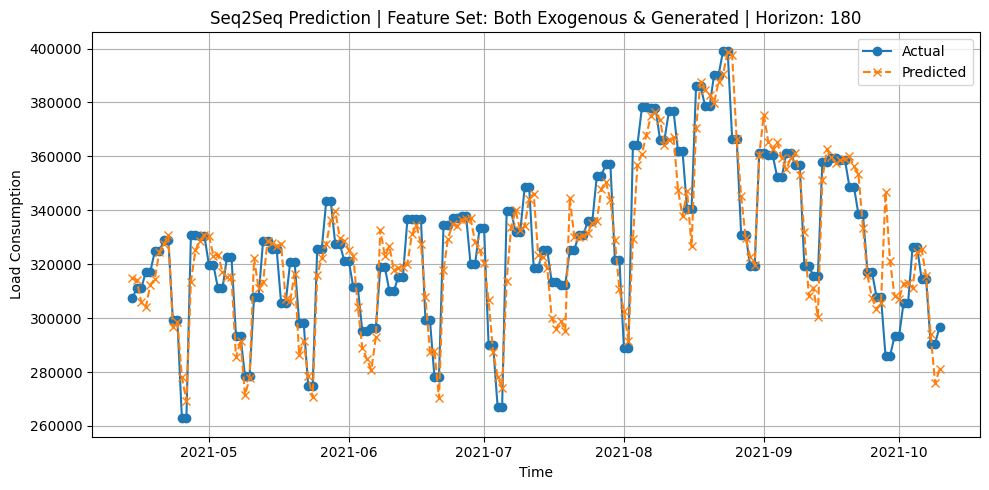

In [46]:
# Plot last prediction sequence
sample_index = -1  # last test sample
Y_pred_sample = Y_pred_test[sample_index].reshape(-1, 1)
Y_true_sample = Y_test[sample_index].reshape(-1, 1)

Y_pred_sample_inv = scaler_target.inverse_transform(Y_pred_sample)
Y_true_sample_inv = scaler_target.inverse_transform(Y_true_sample)

# Optionally: derive start date
test_start_idx = split_index + INPUT_LENGTH + horizon + sample_index
plot_start_date = df_models.index[test_start_idx] if hasattr(df_models.index, 'dtype') and np.issubdtype(df_models.index.dtype, np.datetime64) else None

# Plot
plot_seq2seq_prediction(
    Y_true_seq=Y_true_sample_inv.flatten(),
    Y_pred_seq=Y_pred_sample_inv.flatten(),
    horizon=horizon,
    start_date=plot_start_date,
    title=f"Seq2Seq Prediction | Feature Set: {fs_name} | Horizon: {horizon}"
)


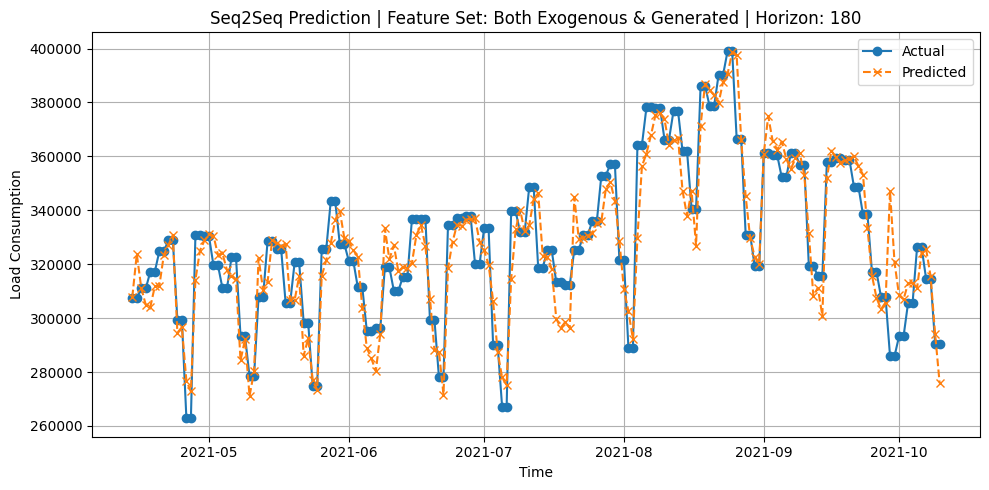

In [47]:
# Plot last prediction sequence
sample_index = -2  # last test sample
Y_pred_sample = Y_pred_test[sample_index].reshape(-1, 1)
Y_true_sample = Y_test[sample_index].reshape(-1, 1)

Y_pred_sample_inv = scaler_target.inverse_transform(Y_pred_sample)
Y_true_sample_inv = scaler_target.inverse_transform(Y_true_sample)

# Optionally: derive start date
test_start_idx = split_index + INPUT_LENGTH + horizon + sample_index
plot_start_date = df_models.index[test_start_idx] if hasattr(df_models.index, 'dtype') and np.issubdtype(df_models.index.dtype, np.datetime64) else None

# Plot
plot_seq2seq_prediction(
    Y_true_seq=Y_true_sample_inv.flatten(),
    Y_pred_seq=Y_pred_sample_inv.flatten(),
    horizon=horizon,
    start_date=plot_start_date,
    title=f"Seq2Seq Prediction | Feature Set: {fs_name} | Horizon: {horizon}"
)


In [48]:
results_seq2seq = pd.DataFrame(results_list)
results_seq2seq[["Feature Set", "Horizon", "nRMSE (%)", "nMAE (%)", "MAPE (%)"]]

,Feature Set,Horizon,nRMSE (%),nMAE (%),MAPE (%)
0,Exogenous Features,1,4.917628,3.910246,4.022264
1,Exogenous Features,7,6.021370,4.231916,4.457214
2,Exogenous Features,30,3.888846,2.717712,2.811849
3,Exogenous Features,90,3.476951,2.331299,2.395477
4,Exogenous Features,180,3.594605,2.622672,2.711361
5,Generated Features,1,3.088668,2.057225,2.107512
6,Generated Features,7,2.975105,1.939176,1.986811
7,Generated Features,30,2.995598,1.982300,2.036603
8,Generated Features,90,2.915401,1.913118,1.967848
9,Generated Features,180,3.284891,2.325289,2.393548


#### save modelsesults

In [49]:
results_seq2seq.to_csv('results\seq2seq1.csv', index =False)

In [50]:
results_sarimax_lstm_df.to_csv('results\sarimax-lstm1.csv', index = False)

In [51]:
sarimax_results_df.to_csv('results\sarimax1.csv', index = False)

In [52]:
df_models.to_csv('temp.csv', index = False)

###  Feartures imapct

In [53]:
def evaluate_sarimax(
    data: pd.DataFrame,
    target_col: str,
    exog_features: list = None,
    horizons: list = [1, 180],
    order: tuple = (1, 0, 1),
    seasonal_order: tuple = (1, 0, 1, 7),
    test_size: float = 0.2
) -> list:
    """
    Evaluate SARIMAX model with and without exogenous features over given forecast horizons.

    Parameters:
        data (pd.DataFrame): Dataset including target and optional exogenous features.
        target_col (str): Name of the target variable column.
        exog_features (list): List of exogenous feature column names (optional).
        horizons (list): List of forecast horizons to evaluate.
        order (tuple): SARIMAX ARIMA order.
        seasonal_order (tuple): SARIMAX seasonal order.
        test_size (float): Fraction of data to use for testing.

    Returns:
        List of dictionaries with error metrics for each model configuration.
    """

    results = []

    train_df, test_df = train_test_split(data, test_size=test_size, shuffle=False)
    y_train = train_df[target_col]
    y_test = test_df[target_col]

    for horizon in horizons:
        y_test_h = y_test.iloc[:horizon]
        mean_actual = y_test_h.mean()

        # --- With exogenous variables --- #
        if exog_features:
            X_train = train_df[exog_features]
            X_test = test_df[exog_features].iloc[:horizon]

            model_with = SARIMAX(
                endog=y_train,
                exog=X_train,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)

            forecast_with = model_with.get_forecast(steps=horizon, exog=X_test).predicted_mean

            mae_with = mean_absolute_error(y_test_h, forecast_with)
            rmse_with = np.sqrt(mean_squared_error(y_test_h, forecast_with))
            mape_with = np.mean(np.abs((y_test_h - forecast_with) / (y_test_h + 1e-9))) * 100

            results.append({
                "Horizon": horizon,
                "Type": f"With {' & '.join(exog_features)}",
                "nRMSE (%)": (rmse_with / mean_actual) * 100,
                "nMAE (%)": (mae_with / mean_actual) * 100,
                "MAPE (%)": mape_with
            })

        # --- Without exogenous variables --- #
        model_without = SARIMAX(
            endog=y_train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        forecast_without = model_without.get_forecast(steps=horizon).predicted_mean

        mae_wo = mean_absolute_error(y_test_h, forecast_without)
        rmse_wo = np.sqrt(mean_squared_error(y_test_h, forecast_without))
        mape_wo = np.mean(np.abs((y_test_h - forecast_without) / (y_test_h + 1e-9))) * 100

        results.append({
            "Horizon": horizon,
            "Type": "Without Exogenous",
            "nRMSE (%)": (rmse_wo / mean_actual) * 100,
            "nMAE (%)": (mae_wo / mean_actual) * 100,
            "MAPE (%)": mape_wo
        })

    return results


In [54]:
data.columns

Index(['date', 'loadConsumption', 'DailyPrecipitation', 'DailyMeanTemperature',
       'DailyMeanWindspeed', 'Month', 'Year', 'Week', 'day_of_week',
       'Population', 'TotalBiomass (MWh)',
       'TotalRes(incl.Stat.Transfer) (MWh)', 'Totaal windenergie (MWh)',
       'TotalSolarEnergy (MWh)', 'AveragePrice_Electricity_Household',
       'AveragePrice_NaturalGas_Household', 'GDP'],
      dtype='object')

In [55]:
renewable_data = data[['date', 'loadConsumption','Totaal windenergie (MWh)','TotalSolarEnergy (MWh)', 'TotalBiomass (MWh)',
       'TotalRes(incl.Stat.Transfer) (MWh)']].copy()

In [56]:
renewable_results = evaluate_sarimax(
    data=renewable_data,
    target_col='loadConsumption',
    exog_features=[  
        'Totaal windenergie (MWh)', 
        'TotalSolarEnergy (MWh)',
        'TotalBiomass (MWh)',
       'TotalRes(incl.Stat.Transfer) (MWh)'
    ],
    horizons=[1, 180]
)


In [57]:
renewable_results = pd.DataFrame(renewable_results)
renewable_results

,Horizon,Type,nRMSE (%),nMAE (%),MAPE (%)
0,1,With Totaal windenergie (MWh) & TotalSolarEner...,1.085654,1.085654,1.085654
1,1,Without Exogenous,2.182117,2.182117,2.182117
2,180,With Totaal windenergie (MWh) & TotalSolarEner...,9.070115,7.544726,7.928215
3,180,Without Exogenous,7.845489,6.686588,6.896612


In [58]:
data_socioeconomic = data[['date', 'loadConsumption', 'Population', 'GDP']].copy()

In [59]:
socio_results = evaluate_sarimax(
    data=data_socioeconomic[['loadConsumption', 'Population', 'GDP']],
    target_col='loadConsumption',
    exog_features=['Population', 'GDP'],
    horizons=[1,180]
)


In [60]:
socio_results = pd.DataFrame(socio_results)

In [61]:
socio_results

,Horizon,Type,nRMSE (%),nMAE (%),MAPE (%)
0,1,With Population & GDP,2.483910,2.483910,2.483910
1,1,Without Exogenous,2.182117,2.182117,2.182117
2,180,With Population & GDP,8.716214,7.341259,7.259613
3,180,Without Exogenous,7.845489,6.686588,6.896612
